# Figure 5a: H5N1 within-host shared SNPs calculation

January 8, 2019 

This notebook contains code for calculating the number and identities of SNPs that are found in at least 2 samples within-host. 

In [47]:
# import necessary modules
import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import rpy2
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
# variant calls file to load in
variant_calls = "~/Documents/H5N1_Cambodian_outbreak_study/Cambodia_H5_sequence_raw_data/combined_human_and_bird_usable_subset/combined_vcfs_nodups/combined_variants_nodups_2018-11-13.txt"

In [49]:
snps_df = pd.read_csv(variant_calls, sep='\t', header='infer')
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [50]:
# get rid of the incorrect variant call due to a mismatched reference base
snps_df = snps_df[snps_df['coding_region_change'] != 'Xaa240Gly']
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN


In [51]:
# change NAs to neuramindase
snps_df['gene'].fillna('neuraminidase', inplace=True)

In [52]:
# make a new column that just has the amino acid number 
snps_df['original_aa'] = snps_df['coding_region_change'].replace('([A-z*]{3})([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['amino_acid_site_change'] = snps_df['coding_region_change'].replace('[A-z*]{3}([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['aa_site'] = snps_df['coding_region_change'].replace('[A-z*]{3}([0-9]+)[A-z*]{3}', '\\1', regex=True)
snps_df['new_aa'] = snps_df['coding_region_change'].replace('([A-z*]{3})([0-9]+)([A-z*]{3})', '\\3', regex=True)
snps_df['amino_acid_site_change'] = snps_df['gene'] + " " + snps_df['amino_acid_site_change'] + " " + snps_df['new_aa']
snps_df['amino_acid_site'] = snps_df['gene'] + " " + snps_df['aa_site'] + " "+ snps_df['synonymous_nonsynonymous']
snps_df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,Unnamed: 10,original_aa,amino_acid_site_change,aa_site,new_aa,amino_acid_site
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,Ala,HA 265 Thr,265,Thr,HA 265 nonsynonymous
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,NaN,Gln,NP 117 Arg,117,Arg,NP 117 nonsynonymous
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,NaN,Ala,PA 307 Ala,307,Ala,PA 307 synonymous
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,NaN,Arg,PA 367 Lys,367,Lys,PA 367 nonsynonymous
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,NaN,Pro,PA 530 Pro,530,Pro,PA 530 synonymous


In [53]:
# select only the 3 columns we want

# hash out this top line (if only want to compare polymorphic site locations) of 2nd line (if want to compare the actual amino acid changes at that site as well)
#df = snps_df[['sample','frequency','amino_acid_site_change']]
df = snps_df[['sample','frequency','amino_acid_site']]
df.head()
set(df['sample'])

{'A/CAMBODIA/V0401301/2011',
 'A/CAMBODIA/V0417301/2011',
 'A/Cambodia/W0112303/2012',
 'A/Cambodia/X0125302/2013',
 'A/Cambodia/X0128304/2013',
 'A/Cambodia/X0207301/2013',
 'A/Cambodia/X0219301/2013',
 'A/Cambodia/X1030304/2013',
 'A/duck/Cambodia/083D1/2011',
 'A/duck/Cambodia/381W11M4/2013',
 'A/duck/Cambodia/PV027D1/2010',
 'A/duck/Cambodia/Y0224301/2014',
 'A/duck/Cambodia/Y0224304/2014'}

In [54]:
# find duplicate rows; output the number of duplicate rows
sum(df.duplicated())

0

In [55]:
# cast data into long format
#df.set_index(inplace=True)
df_pivot = df.pivot_table(index='sample', columns='amino_acid_site', values='frequency')
df_pivot

amino_acid_site,HA 102 synonymous,HA 129 nonsynonymous,HA 136 nonsynonymous,HA 141 nonsynonymous,HA 141 synonymous,HA 142 nonsynonymous,HA 148 synonymous,HA 150 nonsynonymous,HA 166 nonsynonymous,HA 171 synonymous,HA 172 nonsynonymous,HA 173 nonsynonymous,HA 176 nonsynonymous,HA 197 nonsynonymous,HA 198 nonsynonymous,HA 210 nonsynonymous,HA 222 nonsynonymous,HA 226 nonsynonymous,HA 232 nonsynonymous,HA 238 nonsynonymous,HA 252 nonsynonymous,HA 265 nonsynonymous,HA 265 synonymous,HA 307 nonsynonymous,HA 322 nonsynonymous,HA 352 synonymous,HA 357 synonymous,HA 363 nonsynonymous,HA 377 synonymous,HA 407 synonymous,HA 418 nonsynonymous,HA 448 synonymous,HA 461 synonymous,HA 46p stop_gained,HA 476 synonymous,HA 502 synonymous,HA 503 nonsynonymous,HA 506 nonsynonymous,HA 534 synonymous,HA 91 nonsynonymous,M1 159 synonymous,M1 168 nonsynonymous,M1 185 nonsynonymous,M1 194p stop_gained,M1 198 synonymous,M1 199 nonsynonymous,M1 205 nonsynonymous,M1 220 synonymous,M1 227 nonsynonymous,M1 231 synonymous,M1 239 synonymous,M1 243 synonymous,M1 26 nonsynonymous,M1 27 synonymous,M1 30 nonsynonymous,M1 45 nonsynonymous,M2 10 nonsynonymous,M2 13 nonsynonymous,M2 50 nonsynonymous,M2 77 synonymous,M2 85 nonsynonymous,M2 89p stop_gained,NEP 24 nonsynonymous,NEP 47 nonsynonymous,NEP 55 nonsynonymous,NEP 57 synonymous,NP 108 nonsynonymous,NP 109 nonsynonymous,NP 114 synonymous,NP 116 synonymous,NP 117 nonsynonymous,NP 124 synonymous,NP 166 nonsynonymous,NP 168 synonymous,NP 170 nonsynonymous,NP 188 nonsynonymous,NP 201 synonymous,NP 202 synonymous,NP 215 nonsynonymous,NP 220 nonsynonymous,NP 225 nonsynonymous,NP 244 synonymous,NP 245 nonsynonymous,NP 246 nonsynonymous,NP 257 synonymous,NP 260 nonsynonymous,NP 267 nonsynonymous,NP 328 synonymous,NP 339 synonymous,NP 362 synonymous,NP 37 synonymous,NP 383 synonymous,NP 391 synonymous,NP 403 nonsynonymous,NP 403 synonymous,NP 427 synonymous,NP 480 nonsynonymous,NP 50 synonymous,NP 59 synonymous,NP 69 synonymous,NP 98 nonsynonymous,NS1 121 synonymous,NS1 129 synonymous,NS1 159 nonsynonymous,NS1 176 synonymous,NS1 199 synonymous,NS1 207 nonsynonymous,NS1 210 nonsynonymous,NS1 92 synonymous,PA 142 nonsynonymous,PA 157 nonsynonymous,PA 169 nonsynonymous,PA 230p stop_gained,PA 237 nonsynonymous,PA 247 synonymous,PA 259 synonymous,PA 262 nonsynonymous,PA 298 synonymous,PA 307 synonymous,PA 318 nonsynonymous,PA 35 nonsynonymous,PA 359 nonsynonymous,PA 366 synonymous,PA 367 nonsynonymous,PA 399 synonymous,PA 426 nonsynonymous,PA 432 nonsynonymous,PA 466 nonsynonymous,PA 469 synonymous,PA 497 synonymous,PA 505 nonsynonymous,PA 507 synonymous,PA 530 synonymous,PA 556 synonymous,PA 570 synonymous,PA 589 nonsynonymous,PA 610 nonsynonymous,PA 623 synonymous,PA 630 synonymous,PA 631 nonsynonymous,PA 638 synonymous,PA 659 nonsynonymous,PA 679 synonymous,PA 68 nonsynonymous,PA 85 nonsynonymous,PA 93 synonymous,PB1 104 synonymous,PB1 144 nonsynonymous,PB1 211 nonsynonymous,PB1 215 nonsynonymous,PB1 265 nonsynonymous,PB1 279 synonymous,PB1 313 synonymous,PB1 317 nonsynonymous,PB1 334 synonymous,PB1 353 nonsynonymous,PB1 371 synonymous,PB1 379 nonsynonymous,PB1 389 nonsynonymous,PB1 402 synonymous,PB1 415 synonymous,PB1 484 nonsynonymous,PB1 527 nonsynonymous,PB1 537 synonymous,PB1 566 nonsynonymous,PB1 586 synonymous,PB1 589 nonsynonymous,PB1 590 synonymous,PB1 601 synonymous,PB1 627 synonymous,PB1 684 synonymous,PB1 690 synonymous,PB1 700 synonymous,PB1 71 nonsynonymous,PB1 76 nonsynonymous,PB1 85 synonymous,PB2 151 nonsynonymous,PB2 165 nonsynonymous,PB2 178 nonsynonymous,PB2 182 synonymous,PB2 183 synonymous,PB2 222 synonymous,PB2 245 synonymous,PB2 257 synonymous,PB2 262 synonymous,PB2 264 synonymous,PB2 265 nonsynonymous,PB2 290 synonymous,PB2 348 nonsynonymous,PB2 363 synonymous,PB2 392 nonsynonymous,PB2 441 synonymous,PB2 478 synonymous,PB2 479 synonymous,PB2 486 synonymous,PB2 494 synonymous,PB2 505 synonymous,PB2 532 nonsynonymous,PB2 540 nonsynonymous,PB2 579 nonsynonymous,PB2 584 nonsynonymous,PB2 585 synony

In [56]:
# output the number of columns with only a single entry 
singles = (df_pivot.count(numeric_only=True) == 1).sum()
singles

225

In [57]:
# output the number of columns with multiple entries (were present in multiple samples) 
non_singles = (df_pivot.count(numeric_only=True) != 1).sum()
non_singles

14

In [58]:
# convert NaNs to 0s
df_pivot = df_pivot.replace(np.nan,0, regex=False)
df_pivot.head()

amino_acid_site,HA 102 synonymous,HA 129 nonsynonymous,HA 136 nonsynonymous,HA 141 nonsynonymous,HA 141 synonymous,HA 142 nonsynonymous,HA 148 synonymous,HA 150 nonsynonymous,HA 166 nonsynonymous,HA 171 synonymous,HA 172 nonsynonymous,HA 173 nonsynonymous,HA 176 nonsynonymous,HA 197 nonsynonymous,HA 198 nonsynonymous,HA 210 nonsynonymous,HA 222 nonsynonymous,HA 226 nonsynonymous,HA 232 nonsynonymous,HA 238 nonsynonymous,HA 252 nonsynonymous,HA 265 nonsynonymous,HA 265 synonymous,HA 307 nonsynonymous,HA 322 nonsynonymous,HA 352 synonymous,HA 357 synonymous,HA 363 nonsynonymous,HA 377 synonymous,HA 407 synonymous,HA 418 nonsynonymous,HA 448 synonymous,HA 461 synonymous,HA 46p stop_gained,HA 476 synonymous,HA 502 synonymous,HA 503 nonsynonymous,HA 506 nonsynonymous,HA 534 synonymous,HA 91 nonsynonymous,M1 159 synonymous,M1 168 nonsynonymous,M1 185 nonsynonymous,M1 194p stop_gained,M1 198 synonymous,M1 199 nonsynonymous,M1 205 nonsynonymous,M1 220 synonymous,M1 227 nonsynonymous,M1 231 synonymous,M1 239 synonymous,M1 243 synonymous,M1 26 nonsynonymous,M1 27 synonymous,M1 30 nonsynonymous,M1 45 nonsynonymous,M2 10 nonsynonymous,M2 13 nonsynonymous,M2 50 nonsynonymous,M2 77 synonymous,M2 85 nonsynonymous,M2 89p stop_gained,NEP 24 nonsynonymous,NEP 47 nonsynonymous,NEP 55 nonsynonymous,NEP 57 synonymous,NP 108 nonsynonymous,NP 109 nonsynonymous,NP 114 synonymous,NP 116 synonymous,NP 117 nonsynonymous,NP 124 synonymous,NP 166 nonsynonymous,NP 168 synonymous,NP 170 nonsynonymous,NP 188 nonsynonymous,NP 201 synonymous,NP 202 synonymous,NP 215 nonsynonymous,NP 220 nonsynonymous,NP 225 nonsynonymous,NP 244 synonymous,NP 245 nonsynonymous,NP 246 nonsynonymous,NP 257 synonymous,NP 260 nonsynonymous,NP 267 nonsynonymous,NP 328 synonymous,NP 339 synonymous,NP 362 synonymous,NP 37 synonymous,NP 383 synonymous,NP 391 synonymous,NP 403 nonsynonymous,NP 403 synonymous,NP 427 synonymous,NP 480 nonsynonymous,NP 50 synonymous,NP 59 synonymous,NP 69 synonymous,NP 98 nonsynonymous,NS1 121 synonymous,NS1 129 synonymous,NS1 159 nonsynonymous,NS1 176 synonymous,NS1 199 synonymous,NS1 207 nonsynonymous,NS1 210 nonsynonymous,NS1 92 synonymous,PA 142 nonsynonymous,PA 157 nonsynonymous,PA 169 nonsynonymous,PA 230p stop_gained,PA 237 nonsynonymous,PA 247 synonymous,PA 259 synonymous,PA 262 nonsynonymous,PA 298 synonymous,PA 307 synonymous,PA 318 nonsynonymous,PA 35 nonsynonymous,PA 359 nonsynonymous,PA 366 synonymous,PA 367 nonsynonymous,PA 399 synonymous,PA 426 nonsynonymous,PA 432 nonsynonymous,PA 466 nonsynonymous,PA 469 synonymous,PA 497 synonymous,PA 505 nonsynonymous,PA 507 synonymous,PA 530 synonymous,PA 556 synonymous,PA 570 synonymous,PA 589 nonsynonymous,PA 610 nonsynonymous,PA 623 synonymous,PA 630 synonymous,PA 631 nonsynonymous,PA 638 synonymous,PA 659 nonsynonymous,PA 679 synonymous,PA 68 nonsynonymous,PA 85 nonsynonymous,PA 93 synonymous,PB1 104 synonymous,PB1 144 nonsynonymous,PB1 211 nonsynonymous,PB1 215 nonsynonymous,PB1 265 nonsynonymous,PB1 279 synonymous,PB1 313 synonymous,PB1 317 nonsynonymous,PB1 334 synonymous,PB1 353 nonsynonymous,PB1 371 synonymous,PB1 379 nonsynonymous,PB1 389 nonsynonymous,PB1 402 synonymous,PB1 415 synonymous,PB1 484 nonsynonymous,PB1 527 nonsynonymous,PB1 537 synonymous,PB1 566 nonsynonymous,PB1 586 synonymous,PB1 589 nonsynonymous,PB1 590 synonymous,PB1 601 synonymous,PB1 627 synonymous,PB1 684 synonymous,PB1 690 synonymous,PB1 700 synonymous,PB1 71 nonsynonymous,PB1 76 nonsynonymous,PB1 85 synonymous,PB2 151 nonsynonymous,PB2 165 nonsynonymous,PB2 178 nonsynonymous,PB2 182 synonymous,PB2 183 synonymous,PB2 222 synonymous,PB2 245 synonymous,PB2 257 synonymous,PB2 262 synonymous,PB2 264 synonymous,PB2 265 nonsynonymous,PB2 290 synonymous,PB2 348 nonsynonymous,PB2 363 synonymous,PB2 392 nonsynonymous,PB2 441 synonymous,PB2 478 synonymous,PB2 479 synonymous,PB2 486 synonymous,PB2 494 synonymous,PB2 505 synonymous,PB2 532 nonsynonymous,PB2 540 nonsynonymous,PB2 579 nonsynonymous,PB2 584 nonsynonymous,PB2 585 synony

### subset dataframe to include only columns with > 1 entry 

In [59]:
# take the df_pivot indices (samples) and write out to the list, "samples"
samples = list(df_pivot.index)

In [60]:
# make a new dataframe, with the samples list and set the indices to samples
nonsingles_df = pd.DataFrame(samples, columns=['samples']).set_index(['samples'])
nonsingles_df

""
samples
A/CAMBODIA/V0401301/2011
A/CAMBODIA/V0417301/2011
A/Cambodia/W0112303/2012
A/Cambodia/X0125302/2013
A/Cambodia/X0128304/2013
A/Cambodia/X0207301/2013
A/Cambodia/X0219301/2013
A/Cambodia/X1030304/2013
A/duck/Cambodia/083D1/2011


In [61]:
# loop through all of the columns in df_pivot; if that column contains 13 0s, move on; if not, then add it as a new column in df2
for c in df_pivot.columns:
    if ((df_pivot[c] == 0).sum()) <= len(samples) - 2:
        nonsingles_df[c] = df_pivot[c] 
        
nonsingles_df.reset_index(inplace=True)
pd.options.display.max_columns = 4000
nonsingles_df

,samples,HA 141 nonsynonymous,HA 150 nonsynonymous,HA 238 nonsynonymous,HA 307 nonsynonymous,HA 357 synonymous,M1 199 nonsynonymous,NP 201 synonymous,NP 98 nonsynonymous,NS1 92 synonymous,PA 237 nonsynonymous,PA 307 synonymous,PB1 353 nonsynonymous,PB1 371 synonymous,PB2 441 synonymous
0,A/CAMBODIA/V0401301/2011,0.0756,0.2024,0.0280,0.0000,0.0000,0.0000,0.0281,0.0270,0.0000,0.0234,0.0467,0.0000,0.0433,0.0000
1,A/CAMBODIA/V0417301/2011,0.1767,0.0000,0.0805,0.0000,0.0606,0.0000,0.0000,0.0000,0.0000,0.0432,0.0388,0.0000,0.0000,0.0000
2,A/Cambodia/W0112303/2012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0358,0.0294,0.0000,0.0427,0.0000
3,A/Cambodia/X0125302/2013,0.0000,0.1517,0.3729,0.0000,0.0000,0.0000,0.0000,0.0175,0.0256,0.0000,0.0219,0.0258,0.0335,0.0000
4,A/Cambodia/X0128304/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2816,0.0000,0.0000,0.0000,0.0000,0.0000
5,A/Cambodia/X0207301/2013,0.0000,0.0000,0.0000,0.1818,0.0470,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310,0.0000,0.0377,0.0000
6,A/Cambodia/X0219301/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,A/Cambodia/X1030304/2013,0.0000,0.0165,0.0000,0.0616,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0169,0.0000,0.0000
8,A/duck/Cambodia/083D1/2011,0.0000,0.0000,0.0000,0.0000,0.0000,0.0292,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0271,0.0000
9,A/duck/Cambodia/381W11M4/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0455,0.0000,0.0000,0.0319


In [62]:
# put data back into long format and split up sites column
nonsingles_melted = pd.melt(nonsingles_df, id_vars=['samples'])
nonsingles_melted.head()

,samples,variable,value
0,A/CAMBODIA/V0401301/2011,HA 141 nonsynonymous,0.0756
1,A/CAMBODIA/V0417301/2011,HA 141 nonsynonymous,0.1767
2,A/Cambodia/W0112303/2012,HA 141 nonsynonymous,0.0000
3,A/Cambodia/X0125302/2013,HA 141 nonsynonymous,0.0000
4,A/Cambodia/X0128304/2013,HA 141 nonsynonymous,0.0000


In [63]:
# split site ("variable") into 4 columns, gene, site and variant_allele, synonymous/nonsynonymous
nonsingles_melted[['gene','site','syn_nonsyn']] = nonsingles_melted.variable.str.replace(' ', ' ').str.rsplit(n=4, expand=True)
nonsingles_melted.head()

,samples,variable,value,gene,site,syn_nonsyn
0,A/CAMBODIA/V0401301/2011,HA 141 nonsynonymous,0.0756,HA,141,nonsynonymous
1,A/CAMBODIA/V0417301/2011,HA 141 nonsynonymous,0.1767,HA,141,nonsynonymous
2,A/Cambodia/W0112303/2012,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous
3,A/Cambodia/X0125302/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous
4,A/Cambodia/X0128304/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous


In [64]:
# convert site to numeric
nonsingles_melted['site'] = nonsingles_melted['site'].apply(pd.to_numeric, errors='coerce')
nonsingles_melted.head()

,samples,variable,value,gene,site,syn_nonsyn
0,A/CAMBODIA/V0401301/2011,HA 141 nonsynonymous,0.0756,HA,141,nonsynonymous
1,A/CAMBODIA/V0417301/2011,HA 141 nonsynonymous,0.1767,HA,141,nonsynonymous
2,A/Cambodia/W0112303/2012,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous
3,A/Cambodia/X0125302/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous
4,A/Cambodia/X0128304/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous


In [65]:
# make a new column specifying bird or human
nonsingles_melted['species'] = np.where(nonsingles_melted['samples'].str.contains('duck'), 'duck', 'human')
nonsingles_melted.head()

,samples,variable,value,gene,site,syn_nonsyn,species
0,A/CAMBODIA/V0401301/2011,HA 141 nonsynonymous,0.0756,HA,141,nonsynonymous,human
1,A/CAMBODIA/V0417301/2011,HA 141 nonsynonymous,0.1767,HA,141,nonsynonymous,human
2,A/Cambodia/W0112303/2012,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous,human
3,A/Cambodia/X0125302/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous,human
4,A/Cambodia/X0128304/2013,HA 141 nonsynonymous,0.0000,HA,141,nonsynonymous,human


In [66]:
# convert 0s to Nans
nonsingles_melted = nonsingles_melted.replace(0,np.nan, regex=False)

## Plot Figure 5a 

In [67]:
%%R -w 800 -h 500 -u px -i nonsingles_melted  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

nonsingles_melted$genef = factor(nonsingles_melted$gene, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))

p <- ggplot(data=nonsingles_melted, aes(x=site, y=value*100, color=species, shape=syn_nonsyn)) + 
    geom_point(size=2.5)+
    facet_wrap(~genef, scales="free", ncol=4)+
    scale_color_manual(values=c("#99bfaa","#5c3d46"))+
    scale_shape_manual(values=c(19,1,4))+
    labs(x="amino acid site",y="SNP frequency (%)")+
    scale_y_continuous(limits=c(0,50))+
    scale_x_continuous(limits=c(0,500))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=90))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-5a-v1-shared_aa_sites-2019-03-04.pdf", p, width = 14, height = 6, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")

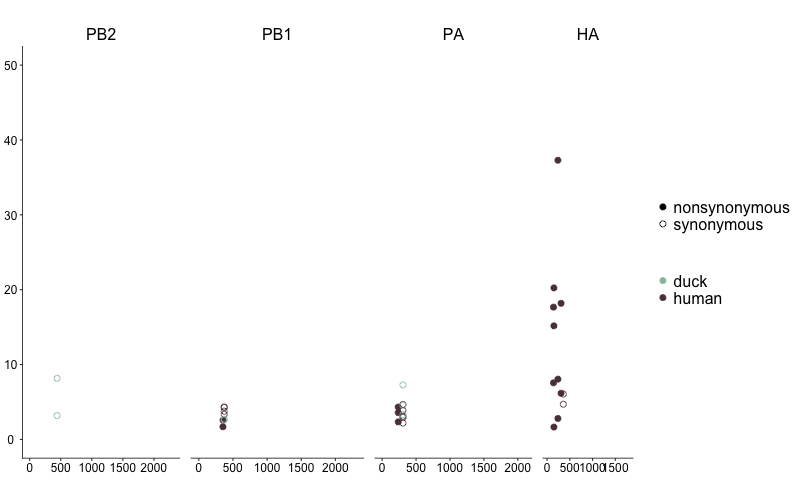

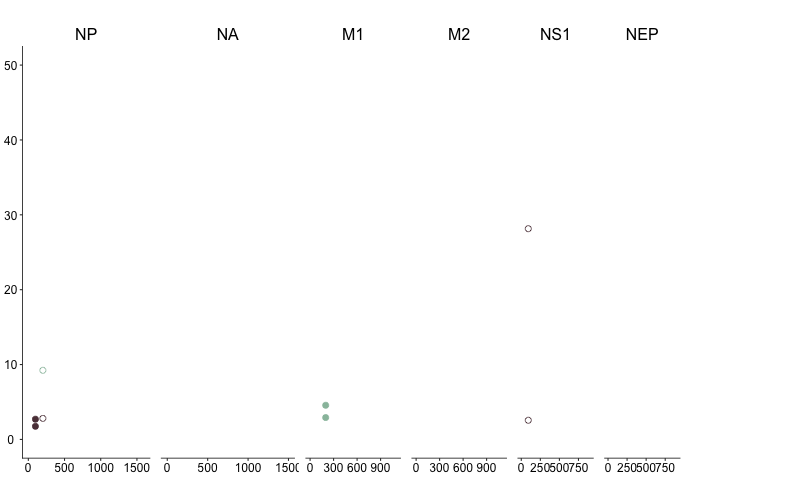

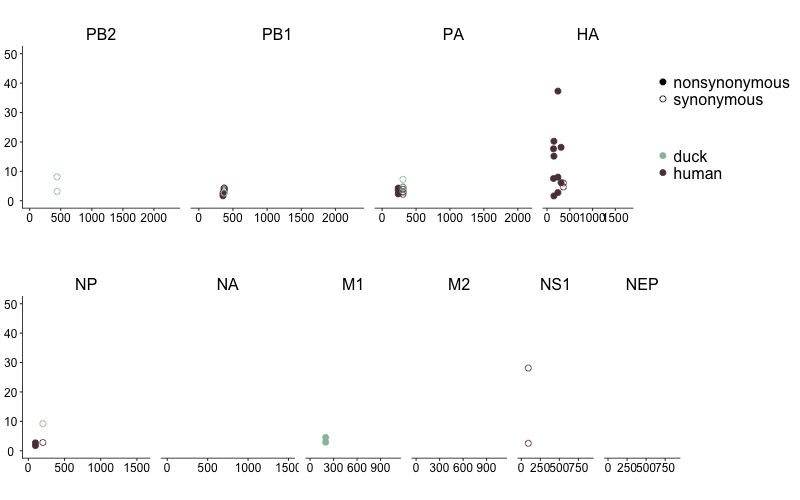

In [68]:
%%R -w 800 -h 500 -u px -i nonsingles_melted  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)
        
human = "#5c3d46"
duck = "#99bfaa"

nonsingles_melted$gene = gsub("neuraminidase","NA", nonsingles_melted$gene)
nonsingles_melted$genef = factor(nonsingles_melted$gene, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))

blank_data <- data.frame(gene_f = c("PB2","PB2","PB1","PB1","PA","PA","HA","HA","NP","NP","NA","NA","M1","M1","M2","M2","NS1","NS1","NEP","NEP"), x = c(0,2500,0,2500,0,2500,0,1800,0,1600,0,1500,0,1200,0,1200,0,1000,0,1000), y = 0, syn_nonsyn="nonsynonymous",species='duck')

nonsingles_melted$syn_nonsyn = gsub("stop_gained","x_mut", nonsingles_melted$syn_nonsyn)

genes = c('PB2','PB1','PA','NP','NA','M1','M2','NS1','NEP')
stops = list('PB2'=2300,'PB1'=2300,'PA'=2100,'HA'=1800,'NP'=1600,'NA'=1500,'M1'=1100,'M2'=1100,'NS1'=900,'NEP'=900)
plots = list()

for (g in genes)
{
    df = nonsingles_melted[nonsingles_melted$gene == g,]
    stop = stops[[g]]
    name = paste(g, "plot",sep = '_')
    
    # set PB2 and NP-specific y-axis aesthetics
    if (g == "PB2"| g == 'NP'){
        y_aesthetics = theme(axis.line.y=element_line(colour="black"))+
        theme(axis.text.y=element_text(hjust=0.5))            
    } else {
        y_aesthetics = theme(axis.line.y=element_blank())+
        theme(axis.ticks.y= element_blank())+
        theme(axis.text.y=element_blank())
    }
        
    p <- ggplot(data=df, aes(x=site, y=value*100, color=species, shape=syn_nonsyn)) + 
        geom_point(size=2.5)+
        geom_blank(data = blank_data, aes(x = x, y = y))+
        theme(panel.grid.major=element_line(colour=NA,size=NA))+
        theme(panel.grid.minor=element_line(colour=NA,size=NA))+
        theme(plot.title=element_text(size=16, hjust=0.5))+
        theme(strip.background = element_rect(colour=NA, fill=NA))+
        theme(plot.margin=unit(c(1,0.15,1,0.15),"cm"))+    # this sets the plot margins as top, left, bottom, right
        theme(axis.line.x=element_line(colour="black"))+
        theme(strip.text.x=element_text(size=13))+
        theme(axis.title.y=element_blank())+#text(size=16, hjust=0.5, vjust=0.5))+
        theme(axis.title.x=element_blank())+#text(size=16, vjust=0.5))+
        theme(axis.text=element_text(size=12, colour="black"))+
        y_aesthetics+
        scale_shape_manual(values=c(19,1,4), labels=c("nonsynonymous","synonymous","missense"), guide=FALSE)+
        scale_color_manual(values=c(duck, human), labels=c("human","duck"), guide=FALSE)+
        theme(legend.text=element_text(size=16))+
        theme(legend.title=element_blank())+
        theme(panel.margin=unit(1, "lines"))+
        theme(panel.background=element_rect(fill=NA, color=NA))+
        theme(legend.key=element_rect(fill=NA))+
        theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
        labs(x="\nnucleotide site",y="SNP frequency (%)\n", title=g)+
        theme(legend.direction = 'horizontal', legend.position = 'right')+
        scale_y_continuous(limits=c(0,50))+
        scale_x_continuous(limits=c(0,stop))
    
    plots[[name]] <- p
} 

# ## add a plot for HA with a legend 
df = nonsingles_melted[nonsingles_melted$gene == "HA",]
ha <- ggplot(data=df, aes(x=site, y=value*100, color=species, shape=syn_nonsyn)) + 
    geom_point(size=2.5)+
    geom_blank(data = blank_data, aes(x = x, y = y))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=16, hjust=0.5))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(1,0.15,1,0.15),"cm"))+    # this sets the plot margins as top, left, bottom, right
    theme(axis.line.x=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=13))+
    theme(axis.title.y=element_blank())+#text(size=16, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_blank())+#text(size=16, vjust=0.5))+
    theme(axis.text=element_text(size=12, colour="black"))+
    theme(axis.line.y=element_blank())+
    theme(axis.ticks.y= element_blank())+
    theme(axis.text.y=element_blank())+
    scale_shape_manual(values=c(19,1,4), labels=c("nonsynonymous","synonymous","missense"))+
    scale_color_manual(values=c(duck, human), labels=c("duck","human"))+
    guides(color = guide_legend(nrow = 2))+
    guides(shape = guide_legend(nrow = 3))+ 
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(panel.background=element_rect(fill=NA, color=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
    labs(x="\nnucleotide site",y="SNP frequency (%)\n", title="HA")+
    theme(legend.direction = 'horizontal', legend.position = 'right')+
    scale_y_continuous(limits=c(0,50))+
    scale_x_continuous(limits=c(0,1800))

extra <- ggplot()+theme(panel.background=element_rect(fill=NA, color=NA))

top <- grid.arrange(plots[[1]],plots[[2]],plots[[3]],ha,ncol=4, widths=c(0.23,0.23,0.21,0.33))
bottom <- grid.arrange(plots[[4]],plots[[5]],plots[[6]],plots[[7]],plots[[8]],plots[[9]], extra, ncol=7, widths=c(0.16,0.15,0.11,0.11,0.09,0.09,0.12))
p <- grid.arrange(top, bottom)
#p
ggsave("Fig-5a-v2-shared_aa_sites-2019-03-04.pdf", p, width = 14, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")

In [69]:
nonsingles_melted['x'] = nonsingles_melted['gene'] + "\n"+ nonsingles_melted['site'].astype(str)
nonsingles_melted.head()

,samples,variable,value,gene,site,syn_nonsyn,species,x
0,A/CAMBODIA/V0401301/2011,HA 141 nonsynonymous,0.0756,HA,141,nonsynonymous,human,HA\n141
1,A/CAMBODIA/V0417301/2011,HA 141 nonsynonymous,0.1767,HA,141,nonsynonymous,human,HA\n141
2,A/Cambodia/W0112303/2012,HA 141 nonsynonymous,NaN,HA,141,nonsynonymous,human,HA\n141
3,A/Cambodia/X0125302/2013,HA 141 nonsynonymous,NaN,HA,141,nonsynonymous,human,HA\n141
4,A/Cambodia/X0128304/2013,HA 141 nonsynonymous,NaN,HA,141,nonsynonymous,human,HA\n141


In [70]:
%%R -w 800 -h 500 -u px -i nonsingles_melted  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

nonsingles_melted$x = factor(nonsingles_melted$x, levels=c("PB2\n441","PB1\n353","PB1\n371","PA\n237","PA\n307",
                                                          "HA\n141","HA\n150","HA\n238","HA\n307","HA\n357",
                                                          "NP\n98","NP\n201","M1\n199","NS1\n92"))

p <- ggplot(data=nonsingles_melted, aes(x=x, y=value*100, color=species, shape=syn_nonsyn)) + 
    geom_point(size=2.5)+
    scale_color_manual(values=c("#99bfaa","#5c3d46"))+
    scale_shape_manual(values=c(19,1,4))+
    labs(x="\namino acid site",y="SNP frequency (%)")+
    scale_y_continuous(limits=c(0,50))+
    #scale_x_continuous(limits=c(0,500))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major.y=element_line(colour=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("Fig-5a-v3-shared_aa_sites-2019-03-04.pdf", p, width = 12, height = 5, device=pdf, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20")

## Calculate the average number of shared SNPs per sample 

In [22]:
nonsingles_df

,samples,HA 141 nonsynonymous,HA 150 nonsynonymous,HA 238 nonsynonymous,HA 307 nonsynonymous,HA 357 synonymous,M1 199 nonsynonymous,NP 201 synonymous,NP 98 nonsynonymous,NS1 92 synonymous,PA 237 nonsynonymous,PA 307 synonymous,PB1 353 nonsynonymous,PB1 371 synonymous,PB2 441 synonymous
0,A/CAMBODIA/V0401301/2011,0.0756,0.2024,0.0280,0.0000,0.0000,0.0000,0.0281,0.0270,0.0000,0.0234,0.0467,0.0000,0.0433,0.0000
1,A/CAMBODIA/V0417301/2011,0.1767,0.0000,0.0805,0.0000,0.0606,0.0000,0.0000,0.0000,0.0000,0.0432,0.0388,0.0000,0.0000,0.0000
2,A/Cambodia/W0112303/2012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0358,0.0294,0.0000,0.0427,0.0000
3,A/Cambodia/X0125302/2013,0.0000,0.1517,0.3729,0.0000,0.0000,0.0000,0.0000,0.0175,0.0256,0.0000,0.0219,0.0258,0.0335,0.0000
4,A/Cambodia/X0128304/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2816,0.0000,0.0000,0.0000,0.0000,0.0000
5,A/Cambodia/X0207301/2013,0.0000,0.0000,0.0000,0.1818,0.0470,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310,0.0000,0.0377,0.0000
6,A/Cambodia/X0219301/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,A/Cambodia/X1030304/2013,0.0000,0.0165,0.0000,0.0616,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0169,0.0000,0.0000
8,A/duck/Cambodia/083D1/2011,0.0000,0.0000,0.0000,0.0000,0.0000,0.0292,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0271,0.0000
9,A/duck/Cambodia/381W11M4/2013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0455,0.0000,0.0000,0.0319


In [23]:
# generate all possible combinations of 2 humans or 2 ducks
import itertools

humans = ["A/CAMBODIA/V0401301/2011","A/CAMBODIA/V0417301/2011","A/Cambodia/W0112303/2012","A/Cambodia/X0125302/2013","A/Cambodia/X0128304/2013","A/Cambodia/X0207301/2013","A/Cambodia/X0219301/2013","A/Cambodia/X1030304/2013"]
ducks = ["A/duck/Cambodia/083D1/2011","A/duck/Cambodia/381W11M4/2013","A/duck/Cambodia/PV027D1/2010","A/duck/Cambodia/Y0224301/2014","A/duck/Cambodia/Y0224304/2014"]

hcombos = itertools.combinations(humans, 2)
dcombos = itertools.combinations(ducks, 2)

# loop through and make dataframes containing each pair of 2 and count the number of shared sites 
duck_pairs = pd.DataFrame()
human_pairs = pd.DataFrame()

for d in dcombos:
    df = nonsingles_df.loc[nonsingles_df["samples"].isin(d)]
    df = df.loc[:, (df != 0).all(axis=0)]   # keep only columns that don't have any 0 values in them 
    shared = len(df.columns) - 1
    
    df2 = pd.DataFrame({'s1': d[0], 's2': d[1], 'shared':shared}, index=[0])
    duck_pairs = duck_pairs.append(df2)
    
for h in hcombos:
    df = nonsingles_df.loc[nonsingles_df["samples"].isin(h)]
    df = df.loc[:, (df != 0).all(axis=0)]
    shared = len(df.columns) - 1
    
    df2 = pd.DataFrame({'s1': h[0], 's2': h[1], 'shared':shared}, index=[0])
    human_pairs = human_pairs.append(df2)

In [24]:
duck_pairs

,s1,s2,shared
0,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/381W11M4/2013,0
0,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/PV027D1/2010,2
0,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/Y0224301/2014,0
0,A/duck/Cambodia/083D1/2011,A/duck/Cambodia/Y0224304/2014,0
0,A/duck/Cambodia/381W11M4/2013,A/duck/Cambodia/PV027D1/2010,1
0,A/duck/Cambodia/381W11M4/2013,A/duck/Cambodia/Y0224301/2014,1
0,A/duck/Cambodia/381W11M4/2013,A/duck/Cambodia/Y0224304/2014,1
0,A/duck/Cambodia/PV027D1/2010,A/duck/Cambodia/Y0224301/2014,1
0,A/duck/Cambodia/PV027D1/2010,A/duck/Cambodia/Y0224304/2014,0
0,A/duck/Cambodia/Y0224301/2014,A/duck/Cambodia/Y0224304/2014,0


In [25]:
human_pairs

,s1,s2,shared
0,A/CAMBODIA/V0401301/2011,A/CAMBODIA/V0417301/2011,4
0,A/CAMBODIA/V0401301/2011,A/Cambodia/W0112303/2012,3
0,A/CAMBODIA/V0401301/2011,A/Cambodia/X0125302/2013,5
0,A/CAMBODIA/V0401301/2011,A/Cambodia/X0128304/2013,0
0,A/CAMBODIA/V0401301/2011,A/Cambodia/X0207301/2013,2
0,A/CAMBODIA/V0401301/2011,A/Cambodia/X0219301/2013,0
0,A/CAMBODIA/V0401301/2011,A/Cambodia/X1030304/2013,1
0,A/CAMBODIA/V0417301/2011,A/Cambodia/W0112303/2012,2
0,A/CAMBODIA/V0417301/2011,A/Cambodia/X0125302/2013,2
0,A/CAMBODIA/V0417301/2011,A/Cambodia/X0128304/2013,0


In [26]:
# take the means 
duck_pairs['shared'].mean()

0.6

In [27]:
human_pairs['shared'].mean()

1.1071428571428572

### Results

A duck sample will on average share 0.6 mutations with another duck sample. Human samples will share 1 mutation on average with another human sample. 

## Calculate the proportion of each sample's variants that are totally unique to that sample

I think that this might be a clearer way to show this

In [28]:
shared_sites = ["HA 141 nonsynonymous","HA 150 nonsynonymous","HA 238 nonsynonymous","HA 307 nonsynonymous","HA 357 synonymous","M1 199 nonsynonymous","NP 201 synonymous","NP 98 nonsynonymous","NS1 92 synonymous","PA 237 nonsynonymous","PA 307 synonymous","PB1 353 nonsynonymous","PB1 371 synonymous","PB2 441 synonymous"]
humans = ["A/CAMBODIA/V0401301/2011","A/CAMBODIA/V0417301/2011","A/Cambodia/W0112303/2012","A/Cambodia/X0125302/2013","A/Cambodia/X0128304/2013","A/Cambodia/X0207301/2013","A/Cambodia/X0219301/2013","A/Cambodia/X1030304/2013"]
ducks = ["A/duck/Cambodia/083D1/2011","A/duck/Cambodia/381W11M4/2013","A/duck/Cambodia/PV027D1/2010","A/duck/Cambodia/Y0224301/2014","A/duck/Cambodia/Y0224304/2014"]

duck_fraction = pd.DataFrame()
human_fraction = pd.DataFrame()

for h in humans: 
    df = snps_df.loc[snps_df['sample'] == h]
    original = len(df)
    
    # subset to include only SNPs that aren't in shared sites 
    df2 = df.loc[~df['amino_acid_site'].isin(shared_sites)]
    unique = len(df2)
    
    fraction_unique = float(unique)/float(original)
    
    df3 = pd.DataFrame({'sample': h, 'total_snps': original, 'unique':unique, 'fraction_unique':fraction_unique}, index=[0])
    
    human_fraction = human_fraction.append(df3)
    
    
for d in ducks: 
    df = snps_df.loc[snps_df['sample'] == d]
    original = len(df)
    
    # subset to include only SNPs that aren't in shared sites 
    df2 = df.loc[~df['amino_acid_site'].isin(shared_sites)]
    unique = len(df2)
    
    fraction_unique = float(unique)/float(original)
    
    df3 = pd.DataFrame({'sample': d, 'total_snps': original, 'unique':unique, 'fraction_unique':fraction_unique}, index=[0])
    
    duck_fraction = duck_fraction.append(df3)

In [29]:
human_fraction

,sample,total_snps,unique,fraction_unique
0,A/CAMBODIA/V0401301/2011,56,48,0.857143
0,A/CAMBODIA/V0417301/2011,18,13,0.722222
0,A/Cambodia/W0112303/2012,24,21,0.875000
0,A/Cambodia/X0125302/2013,30,23,0.766667
0,A/Cambodia/X0128304/2013,48,47,0.979167
0,A/Cambodia/X0207301/2013,25,21,0.840000
0,A/Cambodia/X0219301/2013,10,10,1.000000
0,A/Cambodia/X1030304/2013,17,14,0.823529


In [30]:
duck_fraction

,sample,total_snps,unique,fraction_unique
0,A/duck/Cambodia/083D1/2011,8,6,0.750000
0,A/duck/Cambodia/381W11M4/2013,10,8,0.800000
0,A/duck/Cambodia/PV027D1/2010,4,1,0.250000
0,A/duck/Cambodia/Y0224301/2014,7,6,0.857143
0,A/duck/Cambodia/Y0224304/2014,11,9,0.818182


In [31]:
human_fraction['fraction_unique'].mean(), duck_fraction['fraction_unique'].mean()

(0.8579659780578898, 0.695064935064935)

## Results

In humans, between 72%-100% of any individual's variants are totally unique to that infection. In ducks, 25%-86% are totally unique. 